In [1]:
'''
Purpose of this notebook is to apply preprocessing and feature engineering 
tactics on our metadata, while simultaneously reducing the dimensionality 
of the data given the computational requirements needed to process a large dataset. 
All results are uploaded to an S3 bucket, which also houses our raw .json dataset
'''

'\nPurpose of this notebook is to apply preprocessing and feature engineering \ntactics on our metadata, while simultaneously reducing the dimensionality \nof the data given the computational requirements needed to process a large dataset. \nAll results are uploaded to an S3 bucket, which also houses our raw .json dataset\n'

In [1]:
!pip install awswrangler

In [2]:
# Library imports, setup, etc.
import os
import io
import re
import time
import boto3
import nltk
import warnings
import sagemaker
import pandas as pd
import seaborn as sns
import numpy as np
import awswrangler as wr
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from datetime import datetime
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sagemaker.feature_store.feature_group import FeatureGroup


# Too many warnings, lets suppress them
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

# Session, configuration, important to change in different account
bucket_name = "arxiv-project-bucket"
data_key = "arxiv-metadata-oai-snapshot.json"
role = "arn:aws:iam::221082214706:role/MYLabRole"
region = "us-east-1"
# Path for JSON file in S3
s3_path = f"s3://{bucket_name}/{data_key}"

# Output everything into S3 directory with processed header
output_dir = "./processed_csv"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# S3 prefixes for uploading CSV files
test_prefix = "processed_csv/test"
train_prefix = "processed_csv/train"
val_prefix = "processed_csv/val"

sess = sagemaker.Session(boto_session=boto3.Session(region_name=region))
s3_client = boto3.client('s3', region_name=region)
print("SageMaker Session Bucket:", bucket_name)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[03/04/25 00:16:47] INFO     Found credentials from IAM Role:                                   ]8;id=519403;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=210991;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


[03/04/25 00:16:48] INFO     Found credentials from IAM Role:                                   ]8;id=960998;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=501086;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

[03/04/25 00:16:49] INFO     Found credentials from IAM Role:                                   ]8;id=648686;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=258946;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

SageMaker Session Bucket: arxiv-project-bucket


In [3]:
# Need for preprocessing text data
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# Load the raw data from S3 in json format
df = pd.read_json(s3_path, lines=True)
print("Raw shape:", df.shape)

[03/04/25 00:16:52] INFO     Found credentials from IAM Role:                                   ]8;id=878652;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=827120;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

Raw shape: (2647472, 14)


In [5]:
# General info capture
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2647472 entries, 0 to 2647471
Data columns (total 14 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   id              object
 1   submitter       object
 2   authors         object
 3   title           object
 4   comments        object
 5   journal-ref     object
 6   doi             object
 7   report-no       object
 8   categories      object
 9   license         object
 10  abstract        object
 11  versions        object
 12  update_date     object
 13  authors_parsed  object
dtypes: object(14)
memory usage: 282.8+ MB


In [6]:
df.head()

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,0704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,None,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,..."
1,0704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]"
2,0704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,None,None,physics.gen-ph,None,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[[Pan, Hongjun, ]]"
3,0704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,11 pages,None,None,None,math.CO,None,We show that a determinant of Stirling cycle...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2007-05-23,"[[Callan, David, ]]"
4,0704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,None,"Illinois J. Math. 52 (2008) no.2, 681-689",None,None,math.CA math.FA,None,In this paper we show how to compute the $\L...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2013-10-15,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]"


In [7]:
'''
We can see that the data is highly varied per instance. Need to refine with NLP techniques
'''

'\nWe can see that the data is highly varied per instance. Need to refine with NLP techniques\n'

In [8]:
# Sum total NaNs across each feature, see what needs to be dropped
nan_counts = df.isna().sum()
print("NaN counts per column:")
print(nan_counts)
print("Total NaNs in dataset:", nan_counts.sum())

NaN counts per column:
id                      0
submitter           15189
authors                 0
title                   0
comments           676924
journal-ref       1771284
doi               1427738
report-no         2463839
categories              0
license            452794
abstract                0
versions                0
update_date             0
authors_parsed          0
dtype: int64
Total NaNs in dataset: 6807768


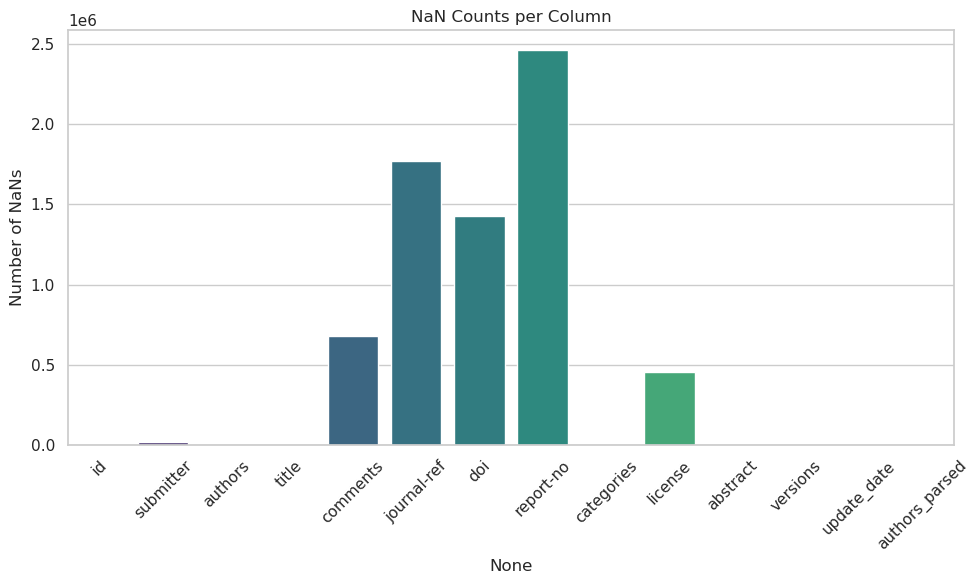

In [9]:
# Many NaN values, let's view them
nan_counts = df.isna().sum()
plt.figure(figsize=(10, 6))
sns.barplot(x=nan_counts.index, y=nan_counts.values, palette="viridis")
plt.xticks(rotation=45)
plt.title("NaN Counts per Column")
plt.ylabel("Number of NaNs")
plt.tight_layout()
plt.show()

In [10]:
'''
We have roughly 2.7 million instances, but in some features, over 1.5 million of those instances
are NaN values. This is too large a percentage to feature engineer, as any replacement, even a 
random imputation based on currently available samples, will cause bias and misleading results.
Simply need to drop feature alltogether.
'''

'\nWe have roughly 2.7 million instances, but in some features, over 1.5 million of those instances\nare NaN values. This is too large a percentage to feature engineer, as any replacement, even a \nrandom imputation based on currently available samples, will cause bias and misleading results.\nSimply need to drop feature alltogether.\n'

In [21]:
'''
In practice, "authors_parsed" and "versions" were causing issues since each instance actually has 
a dictionary nested within them. In future stages, such as training and endpoint deployment, 
they are highly troublesome. Best practice removing them here.
'''

'\nIn practice, "authors_parsed" and "versions" were causing issues since each instance actually has \na dictionary nested within them. In future stages, such as training and endpoint deployment, \nthey are highly troublesome. Best practice removing them here.\n'

In [11]:
# Since submitter is so small, we can remove all NaN instances without affecting the feature itself

In [12]:
# All feature we need to drop for excessive NaN or dictionary instances
columns_to_drop = ['version', 'versions', 'authors_parsed', 'license', 'report-no', 'journal-ref', 'comments', 'doi']

for col in columns_to_drop:
    if col in df.columns:
        df = df.drop(columns=[col])
        print(f"Dropped column: {col}")

print("Hopefully all things are cleaned.", df.shape)

Dropped column: versions
Dropped column: authors_parsed
Dropped column: license
Dropped column: report-no
Dropped column: journal-ref
Dropped column: comments
Dropped column: doi
Hopefully all things are cleaned. (2647472, 7)


In [15]:
# Replace any string "None" with np.nan in all instances
# Replace string "None" with np.nan and drop rows with missing values
df = df.replace("None", np.nan)
print("NaN counts per column:")
print(df.isna().sum())
df.dropna(inplace=True)
print("Total NaNs in dataset:", df.isna().sum().sum())

NaN counts per column:
id             0
submitter      0
authors        0
title          0
categories     0
abstract       0
update_date    0
dtype: int64
Total NaNs in dataset: 0


In [18]:
# TEXT DATA PREPROCESSING

In [19]:
# First, remove stopwords with NLTK
# Also setup for Lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def remove_stop_words(text):
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return " ".join(filtered_tokens)

def remove_punct_numbers(text):
    # Remove all non-alphabetic characters
    return re.sub(r'[^a-zA-Z\s]', '', text)

def lemmatize_text(text):
    tokens = text.split()
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    return " ".join(lemmatized)

In [20]:
# Double check on title and abstract are not missing
df['title'] = df['title'].fillna("")
df['abstract'] = df['abstract'].fillna("")

# Create a new text field by concatenating title and abstract
df['text'] = df['title'] + " " + df['abstract']

# Remove stop words from the text field and convert text to lowercase
df['text'] = df['text'].str.lower().apply(remove_stop_words)

# Remove punctuation and numbers
df['text'] = df['text'].apply(remove_punct_numbers)
# Lemmatization
df['text'] = df['text'].apply(lemmatize_text)

print("Text should be cleaned.")

Text should be cleaned.


In [22]:
df.shape

(2632283, 8)

In [23]:
df["update_date"] = pd.to_datetime(df["update_date"], format="%Y-%m-%d", errors="coerce")
# Organize Data by Date and Filter for the Most Recent 8 Years
df = df.sort_values(by='update_date')
print("Data sorted by update_date.")

Data sorted by update_date.


[03/04/25 00:44:39] INFO     Using categorical units to plot a list of strings that are all         ]8;id=123683;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=358747;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

                    INFO     Using categorical units to plot a list of strings that are all         ]8;id=378529;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=920114;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

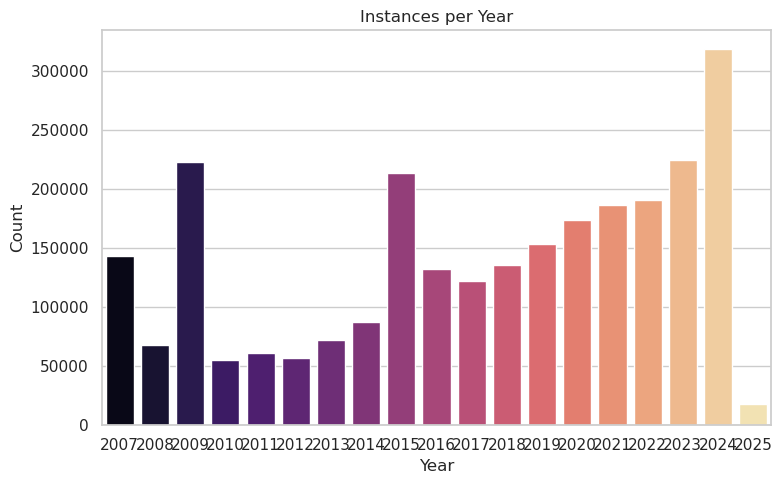

In [24]:
df['year'] = df['update_date'].dt.year
year_counts = df['year'].value_counts().sort_index()
plt.figure(figsize=(8, 5))
sns.barplot(x=year_counts.index.astype(str), y=year_counts.values, palette="magma")
plt.title("Instances per Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [25]:
df['year'] = df['update_date'].dt.year
print("Instances per year:")
print(df['year'].value_counts().sort_index())

Instances per year:
2007    142977
2008     67531
2009    222406
2010     55407
2011     61208
2012     57085
2013     71710
2014     87339
2015    213748
2016    131812
2017    121902
2018    135238
2019    153562
2020    173981
2021    186005
2022    190570
2023    223960
2024    318117
2025     17725
Name: year, dtype: int64


In [26]:
'''
An observation, after data exploration, is that the dataset extends
from 2007 to 2025. However, most early instances contained the NaN
values, indicating that only recently did the datakeeping records of
the ArXiv dataset actually improve. 
'''

'\nAn observation, after data exploration, is that the dataset extends\nfrom 2007 to 2025. However, most early instances contained the NaN\nvalues, indicating that only recently did the datakeeping records of\nthe ArXiv dataset actually improve. \n'

In [27]:
# Find the most recent date and filter our for just the last 8 years
# Memory is a big constraint
max_date = df['update_date'].max()
print("Max date in dataset:", max_date)
eight_years_ago = max_date - pd.DateOffset(years=8)
df_recent = df[df['update_date'] >= eight_years_ago]
print("Data shape after filtering for the most recent 8 years:", df_recent.shape)

Max date in dataset: 2025-01-17 00:00:00
Data shape after filtering for the most recent 8 years: (1516616, 9)


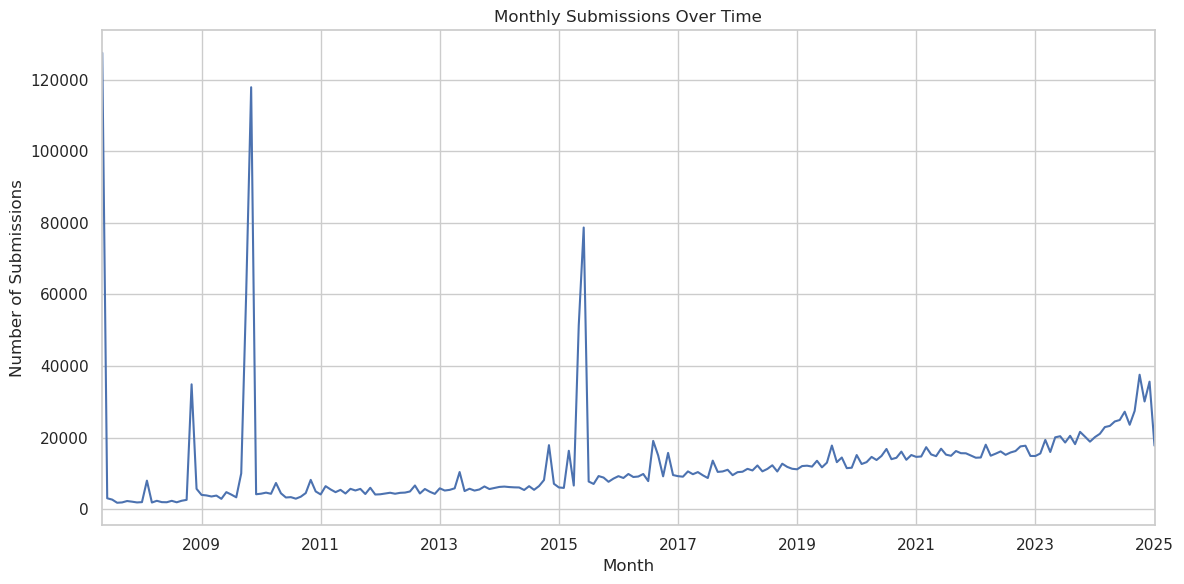

In [28]:
monthly_counts = df.groupby(pd.Grouper(key='update_date', freq='M')).size()
plt.figure(figsize=(12, 6))
monthly_counts.plot()
plt.title("Monthly Submissions Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Submissions")
plt.tight_layout()
plt.show()

In [29]:
# CLEAN AND READY DATA
# CREATION OF FEATURE GROUP/STORE

In [30]:
df_feature_group = df_recent.copy()

# Convert all object columns to string because necessary for Feature Store ingestion
for col in df_feature_group.columns:
    if df_feature_group[col].dtype == "object":
        df_feature_group[col] = df_feature_group[col].astype("string")

# Convert 'update_date' in datetime format to a string so that Feature Store can infer its type.
if "update_date" in df_feature_group.columns:
    df_feature_group["update_date"] = df_feature_group["update_date"].astype("string")

# EventTime column using current time, must be float or ISO format
df_feature_group["EventTime"] = datetime.utcnow().isoformat()

# Generating individualized name
feature_group_name = "arxiv-feature-group-" + datetime.now().strftime("%Y%m%d%H%M%S")
print("Feature Group Name:", feature_group_name)

Feature Group Name: arxiv-feature-group-20250304004702


In [31]:
# FeatureGroup object
feature_group = FeatureGroup(
    name=feature_group_name,
    sagemaker_session=sagemaker.Session(boto_session=boto3.Session(region_name=region))
)

# Load feature definitions from the DataFrame with an inferred schema
feature_group.load_feature_definitions(data_frame=df_feature_group)

# Create the feature group in Feature Store
feature_group.create(
    s3_uri=f"s3://{bucket_name}/feature_store",
    record_identifier_name="id",
    event_time_feature_name="EventTime",
    role_arn=role,
    enable_online_store=True
)

# Wait for creation to complete
status = feature_group.describe().get("FeatureGroupStatus")
while status == "Creating":
    print("Waiting for feature group creation...")
    time.sleep(5)
    status = feature_group.describe().get("FeatureGroupStatus")
if status != "Created":
    raise RuntimeError(f"Failed to create feature group {feature_group_name}")
print(f"Feature Group {feature_group_name} successfully created.")

[03/04/25 00:47:14] INFO     Found credentials from IAM Role:                                   ]8;id=467098;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=147410;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

Waiting for feature group creation...
Waiting for feature group creation...
Waiting for feature group creation...
Waiting for feature group creation...
Waiting for feature group creation...
Waiting for feature group creation...
Waiting for feature group creation...
Waiting for feature group creation...
Feature Group arxiv-feature-group-20250304004702 successfully created.


In [31]:
'''
Continuing forward, before we upload the data, we need to vectorize and 
reduce it's dimensionality to actually use it. In this project, we 
implement TF-IDF to vectorize and TruncatedSVD for dimensionality reduction,
both with a primary focus of computational and memory restraints.
'''

"\nContinuing forward, before we upload the data, we need to vectorize and \nreduce it's dimensionality to actually use it. In this project, we \nimplement TF-IDF to vectorize and TruncatedSVD for dimensionality reduction,\nboth with a primary focus of computational and memory restraints.\n"

In [32]:
# TF-IDF on the cleaned text field
# Really playing around with max_features, min_df, max_df
# Random, educated guesses on all
tfidf_vectorizer = TfidfVectorizer(max_features=300, min_df=2, max_df=0.8)
tfidf_matrix = tfidf_vectorizer.fit_transform(df_recent['text'])
print("TF-IDF matrix shape:", tfidf_matrix.shape)

TF-IDF matrix shape: (1516616, 300)


In [33]:
# TruncatedSVD to reduce dimensionality which is highly problematic with this project
svd = TruncatedSVD(n_components=50, random_state=39)
X_reduced = svd.fit_transform(tfidf_matrix)
print("Reduced features shape:", X_reduced.shape)

Reduced features shape: (1516616, 50)


In [34]:
# New DataFrame for the reduced features
df_reduced = pd.DataFrame(X_reduced, columns=[f'svd_{i}' for i in range(50)])
# Reset index to ensure alignment, then concatenate with df_recent
df_recent = df_recent.reset_index(drop=True)
df_final = pd.concat([df_recent, df_reduced], axis=1)
print("Final data shape with reduced features:", df_final.shape)

Final data shape with reduced features: (1516616, 59)


In [35]:
# Now we make our data split by year into test, train, validation
df_final['year'] = df_final['update_date'].dt.year
unique_years = sorted(df_final['year'].unique())
print("Unique years in final data:", unique_years)

# Use the most recent 8 years
if len(unique_years) >= 8:
    recent_8_years = unique_years[-8:]
else:
    recent_8_years = unique_years
print("Recent 8 years for splitting:", recent_8_years)

# Split the 8 years into:
# Test: oldest 4 years
# Train: next 2 years
# Validation: most recent 2 years
if len(recent_8_years) == 8:
    train_years = recent_8_years[:4]
    test_years = recent_8_years[4:6]
    val_years = recent_8_years[6:]
else:
    # If fewer than 8, split proportionally (this branch is less likely)
    n = len(recent_8_years)
    train_years = recent_8_years[:n//2]
    test_years = recent_8_years[n//2:n//2+1]
    val_years = recent_8_years[n//2+1:]
    
print("Train years:", train_years)
print("Test years:", test_years)
print("Validation years:", val_years)

# Create DataFrames for each split
dfs_test = {yr: df_final[df_final['year'] == yr] for yr in test_years}
dfs_train = {yr: df_final[df_final['year'] == yr] for yr in train_years}
dfs_val = {yr: df_final[df_final['year'] == yr] for yr in val_years}

for yr, d in dfs_test.items():
    print(f"Test set for {yr}: {d.shape}")
for yr, d in dfs_train.items():
    print(f"Training set for {yr}: {d.shape}")
for yr, d in dfs_val.items():
    print(f"Validation set for {yr}: {d.shape}")


Unique years in final data: [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
Recent 8 years for splitting: [2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
Train years: [2018, 2019, 2020, 2021]
Test years: [2022, 2023]
Validation years: [2024, 2025]
Test set for 2022: (190570, 59)
Test set for 2023: (223960, 59)
Training set for 2018: (135238, 59)
Training set for 2019: (153562, 59)
Training set for 2020: (173981, 59)
Training set for 2021: (186005, 59)
Validation set for 2024: (318117, 59)
Validation set for 2025: (17725, 59)


In [ ]:
# Save Each Years data split as CSV and push to S3
def upload_df_to_s3(df, filename, s3_prefix):
    # In-memory text buffer
    csv_buffer = io.StringIO()
    # Write the DataFrame to the buffer as CSV
    df.to_csv(csv_buffer, index=False)
    # Construct the S3 key (file path)
    s3_key = f"{s3_prefix}/{filename}"
    # Upload CSV to S3 directly from memory
    s3_client.put_object(Bucket=bucket_name, Key=s3_key, Body=csv_buffer.getvalue())
    print(f"Uploaded {filename} to s3://{bucket_name}/{s3_prefix}/")

# For test set (4 consecutive years, one file per year)
for yr, d in dfs_test.items():
    fname = f"arxiv_test_{yr}.csv"
    upload_df_to_s3(d, fname, test_prefix)

# For training set (2 consecutive years, one file per year)
for yr, d in dfs_train.items():
    fname = f"arxiv_train_{yr}.csv"
    upload_df_to_s3(d, fname, train_prefix)

# For validation set (2 consecutive years, one file per year)
for yr, d in dfs_val.items():
    fname = f"arxiv_val_{yr}.csv"
    upload_df_to_s3(d, fname, val_prefix)

Uploaded arxiv_test_2022.csv to s3://arxiv-project-bucket/processed_csv/test/


In [37]:
# Determine the most recent date and filter for the last 8 years
max_date = df['update_date'].max()
print("Max date in dataset:", max_date)
eight_years_ago = max_date - pd.DateOffset(years=8)
df_recent = df[df['update_date'] >= eight_years_ago]
print("Data shape after filtering for the most recent 8 years:", df_recent.shape)

Max date in dataset: 2025-01-17 00:00:00
Data shape after filtering for the most recent 8 years: (1516616, 9)
